<a href="https://colab.research.google.com/github/junwei2110/FreeCodeCamp_MachineLearning/blob/Cats-Dogs-Image-Classifier/fcc_cat_dog_pretrainmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containng both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*



---



For this challenge, you will complete the code below to classify images of dogs and cats. You will use Tensorflow 2.0 and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time. (Extra credit if you get it to 70% accuracy!)

Some of the code is given to you but some code you must fill in to complete this challenge. Read the instruction in each text cell so you will know what you have to do in each code cell.

The first code cell imports the required libraries. The second code cell downloads the data and sets key variables. The third cell is the first place you will write your own code.

The structure of the dataset files that are downloaded looks like this (You will notice that the test directory has no subdirectories and the images are not labeled):
```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```

You can tweak epochs and batch size if you like, but it is not required.

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Now it is your turn! Set each of the variables below correctly. (They should no longer equal `None`.)

Create image generators for each of the three image data sets (train, validation, test). Use `ImageDataGenerator` to read / decode the images and convert them into floating point tensors. Use the `rescale` argument (and no other arguments for now) to rescale the tensors from values between 0 and 255 to values between 0 and 1.

For the `*_data_gen` variables, use the `flow_from_directory` method. Pass in the batch size, directory, target size (`(IMG_HEIGHT, IMG_WIDTH)`), class mode, and anything else required. `test_data_gen` will be the trickiest one. For `test_data_gen`, make sure to pass in `shuffle=False` to the `flow_from_directory` method. This will make sure the final predictions stay is in the order that our test expects. For `test_data_gen` it will also be helpful to observe the directory structure.


After you run the code, the output should look like this:
```
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
```

In [81]:
train_image_generator = ImageDataGenerator(rescale = 1./255)
validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

# Interesting observation is that the target_size argument needs to be the directly after the directory link, else there will be an error
# Remember to change the class_mode from its default categorical to binary, else your validation data may not see an improvement in accuracy when model training
train_data_gen = train_image_generator.flow_from_directory("/content/cats_and_dogs/train" , target_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = batch_size, class_mode = 'binary', shuffle = True )
val_data_gen = validation_image_generator.flow_from_directory('/content/cats_and_dogs/validation', target_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = batch_size, class_mode = 'binary', shuffle = True )

# Because there is no subdirectory in the test folder, if you run the method it will find 0 images belonging to 0 class. The trick is to go one layer above, and change the class
# to the name of the folder, in this case is 'test'
test_data_gen = test_image_generator.flow_from_directory('/content/cats_and_dogs', target_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = batch_size, shuffle = False, classes = ['test'], class_mode = None )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


The batch size determines how many training examples are processed in parallel for training/inference. The batch size at training time can affect how fast and how well your training converges. You can find a discussion of this effect here. Thus, for train_batch_size, it's worth picking a batch size that is neither too small nor too large (as discussed in the previously linked discussion). For some applications, using the largest possible training batches can actually be desirable, but in general, you select it through experiments and validation.

However, for validation_batch_size and test_batch_size, you should pick the largest batch size that your hardware can handle without running out of memory and crashing. Finding this is usually a simple trial and error process. The larger your batch size at inference time, the faster it will be, since more inputs can be processed in parallel.

In [82]:
type(train_data_gen)
# In this case, it is a DirectoryIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.

tensorflow.python.keras.preprocessing.image.DirectoryIterator

The `plotImages` function will be used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities list is optional. This code is given to you. If you created the `train_data_gen` variable correctly, then running the cell below will plot five random training images.

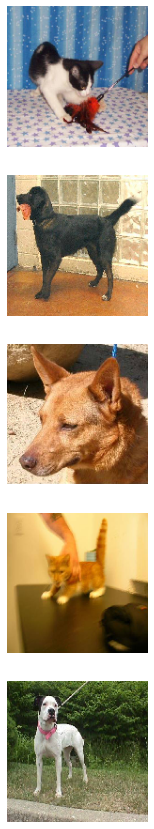

In [83]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3)) # The number of rows = length of the array, the number of columns is 1 and the figsize is the dimensions
    if probabilities is False:
      for img, ax in zip( images_arr, axes): 
 #zip function The zip() function returns a zip object, which is an iterator of tuples 
 # where the first item in each passed iterator is paired together, and then the second item in each passed iterator are paired together etc.
 # so for img,ax in zip(images_arr, axes), it pairs the 1st image to the first ax (0,0), 2nd image to the 2nd ax (1,1), 3rd image to 3rd ax (2,1), ...                
          
          ax.imshow(img)  #Display data as an image, i.e., on a 2D regular raster. The input may either be actual RGB(A) data, or 2D scalar data, which will be rendered as a pseudocolor image.
          ax.axis('off') #removes the axes
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog") 
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen) #The next() function returns the next item from the iterator. The _ means that if train_data_gen has reached the end, the default value will be _
plotImages(sample_training_images[:5]) # there will be 5 rows, 1 column, and each figure will be sized (5x15)


Recreate the `train_image_generator` using `ImageDataGenerator`. 

Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.

Add 4-6 random transformations as arguments to `ImageDataGenerator`. Make sure to rescale the same as before.


In [84]:
train_image_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest' #Default is 'nearest'. Points outside the boundaries of the input are filled according to the given mode

)


In each epoch, the ImageDataGenerator applies a transformation on the images you have and use the transformed images for training. The set of transformations includes rotation, zooming, etc. By doing this you're somehow creating new data (i.e. also called data augmentation), but obviously the generated images are not totally different from the original ones. This way the learned model may be more robust and accurate as it is trained on different variations of the same image.

You need to set the steps_per_epoch argument of fit method to n_samples / batch_size, where n_samples is the total number of training data you have (i.e. 2000 in your case). This way in each epoch, each training sample is augmented only one time and therefore 2000 transformed images will be generated in each epoch.

Further, I think it's worth clarifying the meaning of "augmentation" in this context: basically we are augmenting the images when we use ImageDataGenerator and enabling its augmentation capabilities. But the word "augmentation" here does not mean, say, if we have 100 original training images we end up having 1000 images per epoch after augmentation (i.e. the number of training images does not increase per epoch). Instead, it means we use a different transformation of each image in each epoch; hence, if we train our model for, say, 5 epochs, we have used 5 different versions of each original image in training (or 100 * 5 = 500 different images in the whole training, instead of using just the 100 original images in the whole training). To put it differently, the total number of unique images increases in the whole training from start to finish, and not per epoch.

You don't have to do anything for the next cell. `train_data_gen` is created just like before but with the new `train_image_generator`. Then, a single image is plotted five different times using different variations.

Found 2000 images belonging to 2 classes.


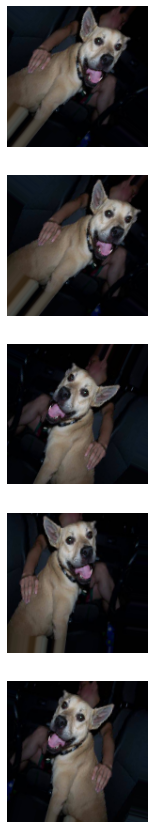

In [85]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [86]:
train_data_gen.shape
# The train_data_gen is a DirectoryIterator - basically provides an interface to view the contents of the directory

AttributeError: ignored

In [87]:
train_data_gen[0].shape
# When you go one dimension in, you realise it is a tuple made of 2 arrays, 1 for the images and the other for the images' labels

AttributeError: ignored

In [88]:
train_data_gen[0][0].shape
# Going one more dimension in, you have removed the labels array and now left with the images array. You can go one more dimension in to just view the first image.

(128, 150, 150, 3)

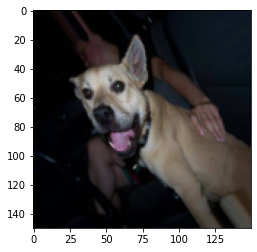

In [89]:
plt.imshow(train_data_gen[0][0][0])

In the cell below, we will use a pretrained model from Google. In this case, we will use the Mobile Net V2.

Compile the model passing the arguments to set the optimizer and loss. Also pass in `metrics=['accuracy']` to view training and validation accuracy for each training epoch.

In [ ]:
from tensorflow.keras import datasets, layers, models

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                              include_top = False,
                                              weights = 'imagenet')

base_model.summary()

In [ ]:
# Next we need to freeze the base
base_model.trainable = False
base_model.summary()

In [92]:
# We add our classifier
# Instead of flattening the feature map of the base layer, we will use a global average pooling layer that will average the entire 5 x 5 area of each 2D feature map and return to us a single 1280 element vector per filter.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [94]:
# We add our prediction layer: Finally we will add the prediction layer that will be a single dense neuron. We can do this because we only have 2 classes to predict for.
prediction_layer = tf.keras.layers.Dense(1)

In [95]:
# We combine all the layers
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [96]:
# Now we train our model

base_learning_rate = 0.0001 #Small learning rate ensures model does not have major changes made to it

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = False), # Binary is for only 2 classes
              metrics = ['accuracy'])

Use the `fit` method on your `model` to train the network. Make sure to pass in arguments for `x`, `steps_per_epoch`, `epochs`, `validation_data`, and `validation_steps`.

In [97]:
history = model.fit(train_data_gen, epochs=epochs,
                    steps_per_epoch=int(np.ceil(total_train / float(batch_size))), 
                    validation_data=val_data_gen,
                    validation_steps=int(np.ceil(total_val / float(batch_size)))
                    )

Epoch 1/15
16/16 [==============================] - 60s 4s/step - loss: 5.7701 - accuracy: 0.5595 - val_loss: 4.9620 - val_accuracy: 0.5720
Epoch 2/15
16/16 [==============================] - 56s 4s/step - loss: 5.0621 - accuracy: 0.5770 - val_loss: 4.0967 - val_accuracy: 0.6260
Epoch 3/15
16/16 [==============================] - 56s 4s/step - loss: 4.3347 - accuracy: 0.6120 - val_loss: 3.4480 - val_accuracy: 0.6620
Epoch 4/15
16/16 [==============================] - 56s 4s/step - loss: 3.7876 - accuracy: 0.6385 - val_loss: 3.0393 - val_accuracy: 0.7000
Epoch 5/15
16/16 [==============================] - 56s 3s/step - loss: 3.3201 - accuracy: 0.6685 - val_loss: 2.7315 - val_accuracy: 0.7240
Epoch 6/15
16/16 [==============================] - 56s 3s/step - loss: 3.0451 - accuracy: 0.6910 - val_loss: 2.4745 - val_accuracy: 0.7450
Epoch 7/15
16/16 [==============================] - 56s 4s/step - loss: 2.8031 - accuracy: 0.7130 - val_loss: 2.1392 - val_accuracy: 0.7740
Epoch 8/15
16/16 [==

Run the next cell to visualize the accuracy and loss of the model.

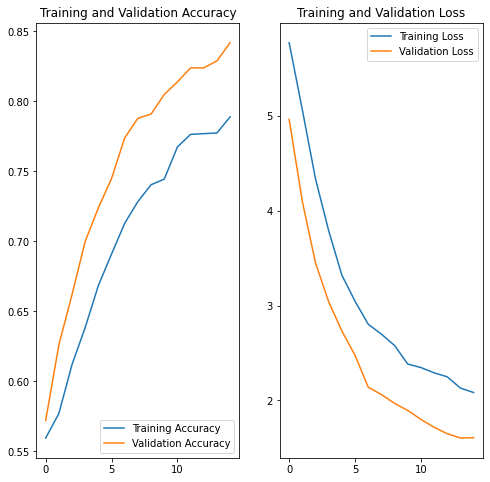

In [98]:
# Accuracy can be seen as the number of errors you made in the dataset
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss is the distance between the true values and the values predicted by the model.
loss = history.history['loss']
val_loss = history.history['val_loss']

# You can get great accuracy and high loss. That means that you made huge errors on a few datapoints
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [99]:
#Time to save the model

model.save("dogs_vs_cats_version2.h5")
# To load the model, use the below command:
# new_model = tf.keras.models.load_model('dogs_vs_cats_version2.h5')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Now it is time to use your model to predict whether a brand new image is a cat or a dog.

In this final cell, get the probability that each test image (from `test_data_gen`) is a dog or a cat. `probabilities` should be a list of integers. 

Call the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

After your run the cell, you should see all 50 test images with a label showing the percentage sure that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

In [107]:
# Note that in this case, the model itself would produce logits instead of probabilities even though I specified logits to be False...
# Anyway, just need to change the logits to probabilities, which is shown here

logit = model.predict(test_data_gen)

# For binary operations
probabilities = tf.round(tf.nn.sigmoid(logit))

# For categorical operations
# probability = tf.nn.softmax(logit)

print(probabilities)

tf.Tensor(
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]], shape=(50, 1), dtype=float32)


Run this final cell to see if you passed the challenge or if you need to keep trying.

In [106]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 0.88% of the images of cats and dogs.
You passed the challenge!
